### Задача:

по замерам акселерометра и гироскопа, произведенным с помощью телефона, находящегося на поясе, научиться отделять различные типы активностей друг от друга.

### План решения:

1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.

In [23]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold

from pyod.models.knn import KNN 

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set()

In [24]:
features_names = pd.read_csv('features.txt', header=None, sep='\s+')
column_names = list(features_names[1])

features = pd.read_csv('X_train.txt', header=None, sep='\s+')
features.columns = column_names
features.head().T


,0,1,2,3,4
tBodyAcc-mean()-X,0.288585,0.278419,0.279653,0.279174,0.276629
tBodyAcc-mean()-Y,-0.020294,-0.016411,-0.019467,-0.026201,-0.016570
tBodyAcc-mean()-Z,-0.132905,-0.123520,-0.113462,-0.123283,-0.115362
tBodyAcc-std()-X,-0.995279,-0.998245,-0.995380,-0.996091,-0.998139
tBodyAcc-std()-Y,-0.983111,-0.975300,-0.967187,-0.983403,-0.980817
...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",-0.464761,-0.732626,0.100699,0.640011,0.693578
"angle(tBodyGyroJerkMean,gravityMean)",-0.018446,0.703511,0.808529,-0.485366,-0.615971
"angle(X,gravityMean)",-0.841247,-0.844788,-0.848933,-0.848649,-0.847865
"angle(Y,gravityMean)",0.179941,0.180289,0.180637,0.181935,0.185151


2. Ознакомьтесь с данными:

a. выведите количество признаков;

b. есть ли в данных пропуски;

c. отличаются ли различные признаки по масштабу.

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [26]:
features.isna().sum().sum()

np.int64(0)

In [27]:
descr = features.describe().T
descr

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000
tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000
tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000
tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000
tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",7352.0,0.008726,0.608303,-1.000000,-0.482273,0.008735,0.506187,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",7352.0,-0.005981,0.477975,-1.000000,-0.376341,-0.000368,0.359368,0.996078
"angle(X,gravityMean)",7352.0,-0.489547,0.511807,-1.000000,-0.812065,-0.709417,-0.509079,1.000000
"angle(Y,gravityMean)",7352.0,0.058593,0.297480,-1.000000,-0.017885,0.182071,0.248353,0.478157


In [28]:
print(descr['mean'].mean())
print(descr['50%'].mean())
print(descr['std'].mean())

-0.508365037734111
-0.6131463817509625
0.2836933644890431


### Вывод:

- В датасете 561 признак.
- Пропуски отсутствуют.
- По масштабу признаки несбалансированы.


3. Понизьте размерность данных:

a. воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

In [29]:
features.shape

(7352, 561)

In [30]:
var = VarianceThreshold(threshold=0.01)
features_th = pd.DataFrame(var.fit_transform(features), columns=features.columns[var.get_support()])

features_th.shape

(7352, 524)

b. воспользуйтесь методом PCA:

i. приведите признаки к одинаковому масштабу,

ii. визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

iii. определите минимальное необходимое количество главных компонент,  при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

iv. выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

In [31]:
features_norm = StandardScaler().fit_transform(features_th.values)
sum([features_norm[:, i].var() for i in range(524)])

np.float64(524.0)

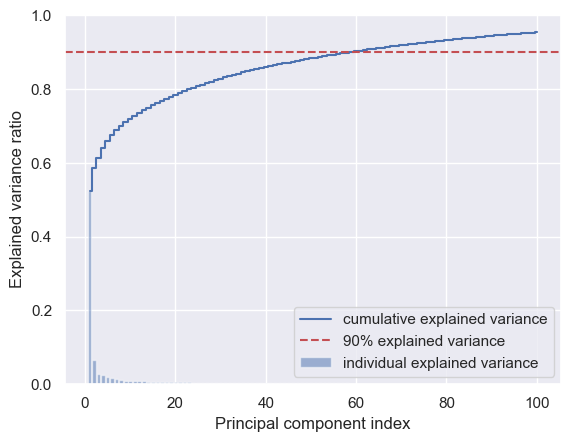

In [32]:
pca = PCA(n_components = 100)
pca.fit(features_norm)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 101), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1, 101), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [33]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_variance >= 0.9)
print(f'Необходимое количество главных компонент для объяснения дисперсии не менее 90%: {n_components_90}')

Необходимое количество главных компонент для объяснения дисперсии не менее 90%: 58


In [34]:
pca = PCA(n_components = 2)
features_reduced = pca.fit_transform(features_norm)

In [35]:
pd.DataFrame(features_reduced).corr()

,0,1
0,1.000000e+00,-2.152456e-16
1,-2.152456e-16,1.000000e+00


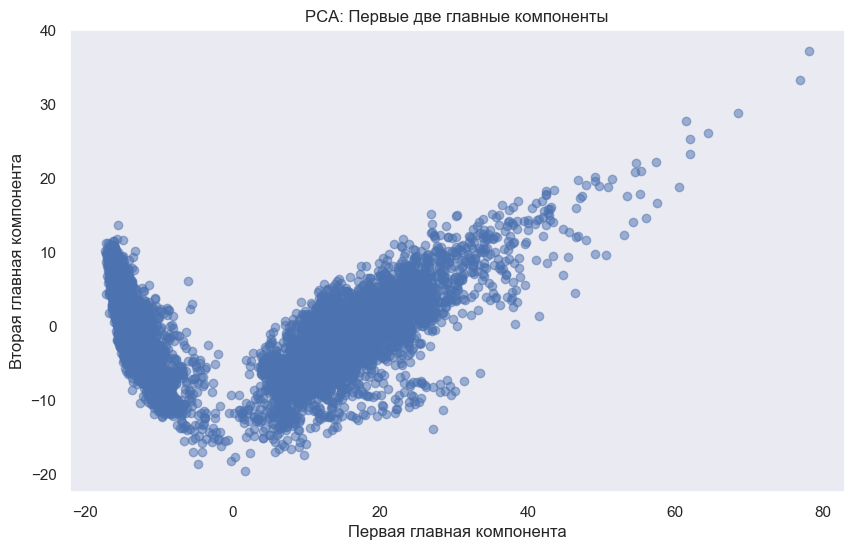

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], alpha=0.5)
plt.title('PCA: Первые две главные компоненты')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid()
plt.show()

4. Подберите оптимальное число кластеров: 

a. воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

b. выберите оптимальное количество кластеров и объясните свой выбор;

c. повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

In [37]:
distortion = []
K = range(1, 10)
for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=4)
    model.fit(features_reduced)
    distortion.append(model.inertia_) 

100%|██████████| 9/9 [00:00<00:00, 65.73it/s]


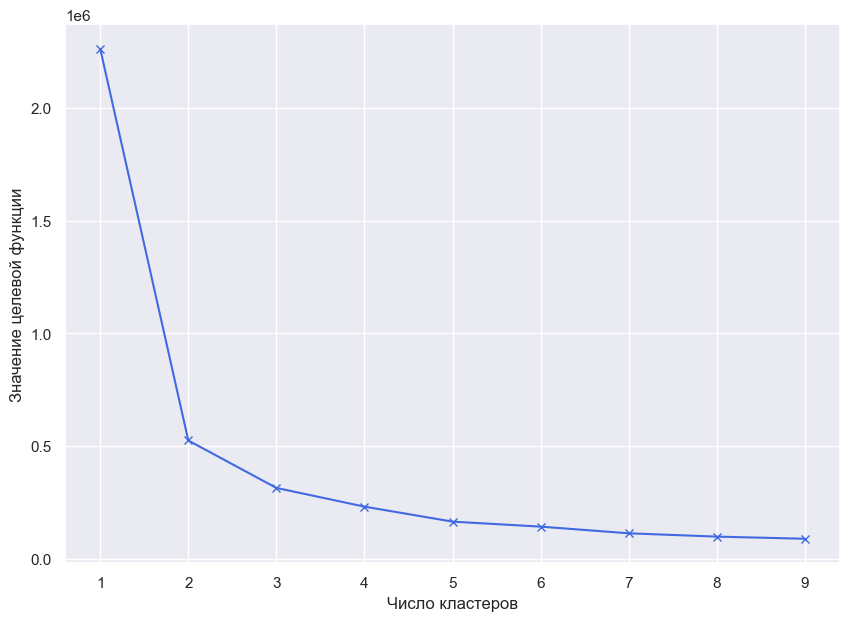

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(K, distortion, c='royalblue', marker='x')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

Оптимальное количество кластеров 2

In [39]:
model = KMeans(2, random_state=12)
clusters = model.fit_predict(features_reduced)

print("Центроиды кластеров:")
print(model.cluster_centers_)

Центроиды кластеров:
[[ 17.05958149  -0.9768291 ]
 [-13.81733705   0.79117867]]


<Axes: xlabel='f1', ylabel='f2'>

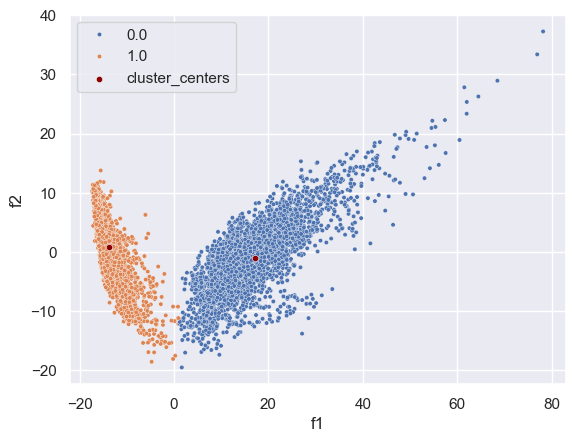

In [40]:
sns.scatterplot(
    data=pd.DataFrame(np.hstack([features_reduced, np.array([model.labels_]).T]), columns=['f1', 'f2', 'label']), 
    x='f1',
    y='f2',
    hue='label', 
    palette='deep',
    s=10
)
sns.scatterplot(
    pd.DataFrame(model.cluster_centers_, columns=['f1', 'f2']), 
    color='darkred', 
    x='f1',
    y='f2',
    s=20,
    label='cluster_centers'
)

5. Оцените качество кластеризации:

a. подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

b. определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

c. сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.

In [41]:
print("Целевая функция:")
print(model.inertia_)

Целевая функция:
524597.822206005


In [42]:
target = pd.read_csv('y_train.txt', header=None, sep='\s+')
target.head()

,0
0,5
1,5
2,5
3,5
4,5


In [43]:
target_names = pd.read_csv('activity_labels.txt', header=None, sep='\s+')
target_dict = dict(zip(target_names[0], target_names[1]))
target_labels = target.replace(target_dict)
target_labels.sample(7)

,0
2731,SITTING
4447,LAYING
2780,LAYING
2857,WALKING_UPSTAIRS
6364,LAYING
2129,LAYING
3652,SITTING


In [44]:
contingency_table = pd.crosstab(target_labels[0], clusters.tolist(),
                                 rownames=['Реальные метки'], colnames=['Кластеры'])
print(contingency_table)

Кластеры               0     1
Реальные метки                
LAYING                11  1396
SITTING                1  1285
STANDING               0  1374
WALKING             1226     0
WALKING_DOWNSTAIRS   986     0
WALKING_UPSTAIRS    1066     7


### Вывод:

Из результатов сводной таблицы видно, что несколько активностей объединились в один кластер. Это может быть связано с тем, что активности имеют схожие характеристики. Например, 'LAYING', 'SITTING' и 'STANDING' описывают статичные позиции, а 'WALKING', 'WALKING_DOWNSTAIRS' и 'WALKING_UPSTAIRS' - позиции движения. Таким образом, считаю данную кластеризацию логичной.